# Logisitic Regression Modeling

In this notebook, we iterate through a logisitic regression baseline, trying different class imbalance remedy methods. We also grid search to try and optomize the baseline's hyperparameters.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns; sns.set()
%matplotlib inline
import nltk
from sklearn.feature_extraction import text 
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix, roc_curve, auc, classification_report
import pickle

## Importing X and y from `nlp_preprocessing.ipynb`

In [2]:
X_lem = pickle.load(open('../pickle/X_lem.pkl', 'rb'))
y_lem = pd.read_pickle('../pickle/y_lem.pkl')

In [3]:
# setting up stop words
stop_words = set(stopwords.words('english'))

## Train-Test Split & Vectorize

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_lem, y_lem, test_size=0.20, random_state=15)

# using tf_idf vectorizor
tfidf = TfidfVectorizer(stop_words= stop_words, ngram_range=(1,2))

In [5]:
# sparse matrix format with 265K stored elements
tfidf_data_train = tfidf.fit_transform(X_train)
tfidf_data_test = tfidf.transform(X_test)

### Class Imbalance in Training Set 

In [6]:
# creating single df for training set
X_train_df = pd.DataFrame(data=tfidf_data_train, index=None, columns=['tweet']) 
y_train_df = pd.DataFrame(data=y_train, index=None, columns=['label']) 
# joining them
training = pd.concat([X_train_df, y_train_df], axis=1)

In [7]:
training.head(2)

,tweet,label
0,"(0, 13916)\t0.3613109053177048\n (0, 28446)...",0.0
1,"(0, 42294)\t0.2767045383753568\n (0, 43280)...",0.0


In [8]:
# separate minority and majority classes
hate = training[training.label==1]
not_hate = training[training.label==0]

In [9]:
hate.shape

(1151, 2)

In [10]:
not_hate.shape

(18675, 2)

We can see that this data has a huge **class imbalance**. After running a baseline, we can try oversampling the minority class (hate speech) with SMOTE and undersampling the majority class with Tomek Links.

## Baseline Logistic Regression


In [11]:
logreg_baseline = LogisticRegression(penalty='l2', class_weight='balanced', random_state=20)
# class_weight='balanced' actually didn't impact the score

In [12]:
%%time
logreg_baseline.fit(tfidf_data_train, y_train)
logreg_test_preds = logreg_baseline.predict(tfidf_data_test)

In [13]:
logreg_precision = precision_score(y_test, logreg_test_preds)
logreg_recall = recall_score(y_test, logreg_test_preds)
logreg_f1_score = f1_score(y_test, logreg_test_preds)
logreg_weighted_f1_score = f1_score(y_test, logreg_test_preds, average='weighted')

In [14]:
# printing evaluation metrics up to 4th decimal place
print('Testing Metrics for Logistic Regression Baseline with Lemmatization Features')
print('Precision: {:.4}'.format(logreg_precision))
print('Recall: {:.4}'.format(logreg_recall))
print('F1 Score: {:.4}'.format(logreg_f1_score))

Testing Metrics for Logistic Regression Baseline with Lemmatization Features
Precision: 0.2939
Recall: 0.5699
F1 Score: 0.3878


In [15]:
# creating dictionary with all metrics
metric_dict = {}
metric_dict['Baseline Logisitic Regression'] = {'precision': logreg_precision, 'recall': logreg_recall, 'f1_score': logreg_f1_score, 'weighted_f1': logreg_weighted_f1_score}

(2.0, 0.0)

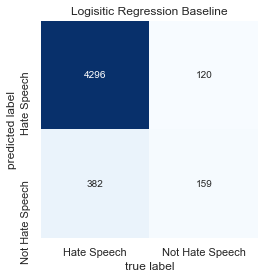

In [16]:
mat = confusion_matrix(y_test, logreg_test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Hate Speech', 'Not Hate Speech'], yticklabels=['Hate Speech', 'Not Hate Speech'], cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Logisitic Regression Baseline')

# fixing matplotlib heatmap cutoff issue
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

## Baseline with SMOTE
Used to over-sample the minority class (hate speech).

In [17]:
# X_train_array = np.asarray(X_train)
# X_train_fix = np.reshape(X_train_array, (-1, 1))
# X_train_final = np.array(list(X_train_fix)).reshape(-1,1)

In [18]:
# y_train_fix = np.reshape(y_train.values, (-1, 1))
# y_train_final = np.array(list(y_train_fix)).reshape(-1,1)

In [19]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=35)
smote_X_train, smote_y_train = sm.fit_sample(tfidf_data_train, y_train)

In [20]:
smote_logreg = LogisticRegression(penalty='l2', random_state=35)

In [21]:
%%time
smote_logreg.fit(smote_X_train, smote_y_train)
smote_logreg_test_preds = smote_logreg.predict(tfidf_data_test)

In [22]:
smote_precision = precision_score(y_test, smote_logreg_test_preds)
smote_recall = recall_score(y_test, smote_logreg_test_preds)
smote_f1_score = f1_score(y_test, smote_logreg_test_preds)
smote_weighted_f1_score = f1_score(y_test, smote_logreg_test_preds, average='weighted')

In [23]:
# printing evaluation metrics up to 4th decimal place
print('Testing Metrics for Oversampled Logistic Regression Baseline with Lemmatization Features')
print('Precision: {:.4}'.format(smote_precision))
print('Recall: {:.4}'.format(smote_recall))
print('F1 Score: {:.4}'.format(smote_f1_score))

Testing Metrics for Oversampled Logistic Regression Baseline with Lemmatization Features
Precision: 0.3207
Recall: 0.5161
F1 Score: 0.3956


In [24]:
metric_dict['Baseline Log Reg Oversampled with SMOTE'] = {'precision': smote_precision, 'recall': smote_recall, 'f1_score': smote_f1_score,  'weighted_f1': smote_weighted_f1_score}

## Baseline with Tomek Links
Used to under-sample the majority class (not hate speech).

In [25]:
from collections import Counter
from imblearn.under_sampling import TomekLinks # doctest: +NORMALIZE_WHITESPACE

tl = TomekLinks()
tomek_X_train, tomek_y_train = tl.fit_resample(tfidf_data_train, y_train)
print('Resampled dataset shape %s' % Counter(tomek_y_train))

Resampled dataset shape Counter({0: 18627, 1: 1151})


It only removed 48 values from the majority class.

In [26]:
tomek_logreg = LogisticRegression(penalty='l2', random_state=55)

In [27]:
%%time
tomek_logreg.fit(tomek_X_train, tomek_y_train)
tomek_logreg_test_preds = tomek_logreg.predict(tfidf_data_test)

In [28]:
tomek_precision = precision_score(y_test, tomek_logreg_test_preds)
tomek_recall = recall_score(y_test, tomek_logreg_test_preds)
tomek_f1_score = f1_score(y_test, tomek_logreg_test_preds)

In [29]:
# printing evaluation metrics up to 4th decimal place
print('Testing Metrics for Undersampled Logistic Regression Baseline with Lemmatization Features')
print('Precision: {:.4}'.format(tomek_precision))
print('Recall: {:.4}'.format(tomek_recall))
print('F1 Score: {:.4}'.format(tomek_f1_score))

Testing Metrics for Undersampled Logistic Regression Baseline with Lemmatization Features
Precision: 0.6909
Recall: 0.1362
F1 Score: 0.2275


In [30]:
metric_dict['Baseline Log Reg Undersampled with Tomek Links'] = {'precision': tomek_precision, 'recall': tomek_recall, 'f1_score': tomek_f1_score}

### Metrics for All Baselines

In [31]:
pd.DataFrame.from_dict(metric_dict, orient='index')

,precision,recall,f1_score
Baseline Logisitic Regression,0.293900,0.569892,0.387805
Baseline Log Reg Oversampled with SMOTE,0.320713,0.516129,0.395604
Baseline Log Reg Undersampled with Tomek Links,0.690909,0.136201,0.227545


Out of all of them, **the baseline oversampled with SMOTE** performed the best. So let's run grid search on that one to find the optimal parameters.

It's important to note that this model produces the same score as a baseline SVM.

## Grid Search without SMOTE

In [32]:
# creating the model
baseline_model = LogisticRegression(class_weight='balanced', random_state=50)

In [33]:
# creating param_dict
param_dict={'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'newton-cg', 'sag'], 'C':
[100, 10, 1.0, 0.1, 0.01]}

In [34]:
# instantiate Grid Search CV with F1 metric
grid_baseline = GridSearchCV(baseline_model, param_dict, cv=5, scoring='f1', verbose=1)

In [35]:
%%time
# fit the grid search to our data
grid_baseline.fit(tfidf_data_train, y_train)

# this cell takes 7 minutes to run

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [36]:
# generate score with .best_score_ and hyperparemeters with .best_params_
print('F1 Score:', grid_baseline.best_score_)
print('Best Hyperparameters:', grid_baseline.best_params_)
print('Model object with best parameters: ')
print(grid_baseline.best_estimator_)

F1 Score: 0.45102957641410335
Best Hyperparameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Model object with best parameters: 
LogisticRegression(class_weight='balanced', random_state=50, solver='liblinear')


In [39]:
# Predict the response for test dataset
grid_base_y_pred_train = grid_baseline.best_estimator_.predict(tfidf_data_train)

# predict the training set
grid_base_y_pred_test = grid_baseline.best_estimator_.predict(tfidf_data_test)

# Model F1, how often is the classifier correct?
print('Tuned Logistic Regression Model Predictions')
print("F1 on train set:",metrics.f1_score(y_train, grid_base_y_pred_train))
print("F1 on test set:",metrics.f1_score(y_test, grid_base_y_pred_test))

Tuned Logistic Regression Model Predictions
F1 on train set: 0.7597876575978765
F1 on test set: 0.38780487804878044


In [ ]:
tuned_base_precision = precision_score(y_test, grid_base_y_pred_test)
tuned_base_recall = recall_score(y_test, grid_base_y_pred_test)
tuned_base_f1_score = f1_score(y_test, grid_base_y_pred_test)

So this didn't really make a difference? This makes sense because there aren't many hyperparameters to tune with logistic regression.

## Running This Tuned Baseline on SMOTE Data

In [43]:
# best model according to grid search
smote_tuned = LogisticRegression(class_weight='balanced', random_state=50, solver='liblinear')

In [44]:
smote_tuned.fit(smote_X_train, smote_y_train)
smote_tuned_test_preds = smote_tuned.predict(tfidf_data_test)

In [45]:
smote_tuned_precision = precision_score(y_test, smote_tuned_test_preds)
smote_tuned_recall = recall_score(y_test, smote_tuned_test_preds)
smote_tuned_f1_score = f1_score(y_test, smote_tuned_test_preds)

In [46]:
# printing evaluation metrics up to 4th decimal place
print('Testing Metrics for Undersampled TUNED Logistic Regression with Lemmatization Features')
print('Precision: {:.4}'.format(smote_tuned_precision))
print('Recall: {:.4}'.format(smote_tuned_recall))
print('F1 Score: {:.4}'.format(smote_tuned_f1_score))

Testing Metrics for Undersampled TUNED Logistic Regression with Lemmatization Features
Precision: 0.3207
Recall: 0.5161
F1 Score: 0.3956


Looks like using grid search can't really improve this F1 score. This model has the same F1 as the baseline SVM.
